In [1]:
!pip install torch torchvision timm albumentations opencv-python numpy scipy PyWavelets matplotlib scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2


In [3]:
def apply_CLAHE(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)


In [4]:
def apply_Fourier(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    magnitude_spectrum = (magnitude_spectrum / np.max(magnitude_spectrum) * 255).astype(np.uint8)
    return cv2.merge([magnitude_spectrum, magnitude_spectrum, magnitude_spectrum])


In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        # Apply CLAHE & Fourier
        clahe_img = apply_CLAHE(image)
        fourier_img = apply_Fourier(image)

        # Augmentation pipeline
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.3)  # Fixed augmentation order
        ])

        original_tensor = transform(Image.fromarray(image))
        clahe_tensor = transform(Image.fromarray(clahe_img))
        fourier_tensor = transform(Image.fromarray(fourier_img))

        # Stack all processed images (9 channels total)
        processed_tensor = torch.cat((original_tensor, clahe_tensor, fourier_tensor), dim=0)

        # Normalize 9 channels separately
        mean = torch.mean(processed_tensor, dim=[1, 2])
        std = torch.std(processed_tensor, dim=[1, 2]) + 1e-6
        processed_tensor = (processed_tensor - mean[:, None, None]) / std[:, None, None]

        return processed_tensor, label


In [ ]:
batch_size = 32
train_dataset = CustomDataset(root_dir="/content/drive/MyDrive/DATASET_SPLIT/TRAIN")
val_dataset = CustomDataset(root_dir="/content/drive/MyDrive/DATASET_SPLIT/VALIDATION")
test_dataset = CustomDataset(root_dir="/content/drive/MyDrive/DATASET_SPLIT/TEST")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(" Custom Dataset Ready with 9-channel normalization and augmentations!")


✅ Custom Dataset Ready with 9-channel normalization and augmentations!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load EfficientNet-B0
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Depthwise Convolution to Reduce Input Channels from 9 → 3
class ModifiedEfficientNet(nn.Module):
    def __init__(self, original_model):
        super(ModifiedEfficientNet, self).__init__()
        self.channel_reduction = nn.Conv2d(9, 3, kernel_size=1)
        self.efficient_net = original_model

    def forward(self, x):
        x = self.channel_reduction(x)
        return self.efficient_net(x)

model = ModifiedEfficientNet(model)

# Modify classifier
model.efficient_net.classifier = nn.Sequential(
    nn.Linear(model.efficient_net.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Increased Dropout
    nn.Linear(512, len(train_dataset.dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(" Model loaded and ready for training!")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 49.1MB/s]


✅ Model loaded and ready for training!


In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=2e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=0.00001)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

#  L2 Regularization and Lower Learning Rate
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

#  Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

#  Early Stopping (Manual Implementation)
early_stopping_patience = 5
no_improve_count = 0
best_val_acc = 0

num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        #  Gradient Clipping (Prevents Exploding Gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation Step
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    #  Learning Rate Adjustment
    scheduler.step(val_loss)

    #  Early Stopping Logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_count = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save Best Model
    else:
        no_improve_count += 1

    #  Stop if No Improvement for "early_stopping_patience" epochs
    if no_improve_count >= early_stopping_patience:
        print(f"⏹️ Early stopping at epoch {epoch + 1}")
        break

    #  Print Results for Each Epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")

print(f"✅ Best Validation Accuracy: {best_val_acc:.2f}%")


Epoch [1/25] - Train Acc: 39.47% | Val Acc: 58.10% | Val Loss: 1.2266
Epoch [2/25] - Train Acc: 64.33% | Val Acc: 73.33% | Val Loss: 0.6894
Epoch [3/25] - Train Acc: 74.60% | Val Acc: 80.00% | Val Loss: 0.4938
Epoch [4/25] - Train Acc: 79.64% | Val Acc: 82.86% | Val Loss: 0.3934
Epoch [5/25] - Train Acc: 83.86% | Val Acc: 87.62% | Val Loss: 0.2954
Epoch [6/25] - Train Acc: 84.57% | Val Acc: 83.81% | Val Loss: 0.3324
Epoch [7/25] - Train Acc: 86.82% | Val Acc: 87.14% | Val Loss: 0.2844
Epoch [8/25] - Train Acc: 87.95% | Val Acc: 86.19% | Val Loss: 0.3150
Epoch [9/25] - Train Acc: 88.01% | Val Acc: 89.05% | Val Loss: 0.2882
Epoch [10/25] - Train Acc: 90.03% | Val Acc: 89.05% | Val Loss: 0.2597
Epoch [11/25] - Train Acc: 90.39% | Val Acc: 90.95% | Val Loss: 0.2379
Epoch [12/25] - Train Acc: 91.16% | Val Acc: 90.00% | Val Loss: 0.2603
Epoch [13/25] - Train Acc: 91.57% | Val Acc: 91.43% | Val Loss: 0.2732
Epoch [14/25] - Train Acc: 92.88% | Val Acc: 90.48% | Val Loss: 0.3239
Epoch [15/25] -

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0     0.8929    0.8929    0.8929        28
           1     0.9167    0.8919    0.9041        37
           2     0.8696    0.8696    0.8696        23
           3     0.9600    1.0000    0.9796        24
           4     0.9091    0.9091    0.9091        33
           5     0.8889    0.7742    0.8276        31
           6     0.8684    0.9706    0.9167        34

    accuracy                         0.9000       210
   macro avg     0.9008    0.9012    0.8999       210
weighted avg     0.9002    0.9000    0.8990       210



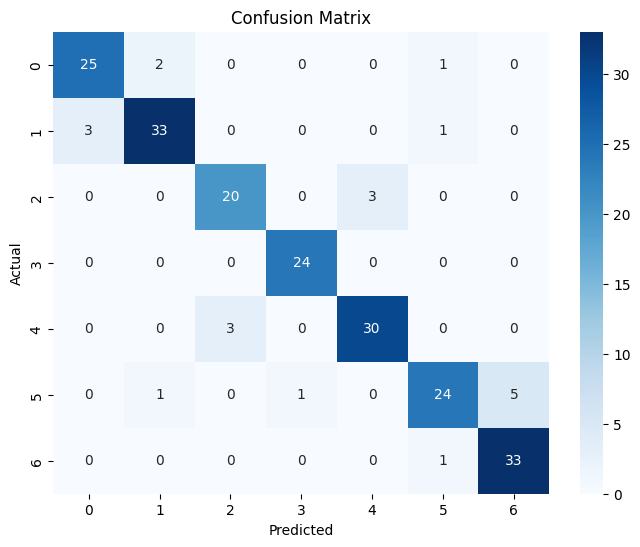

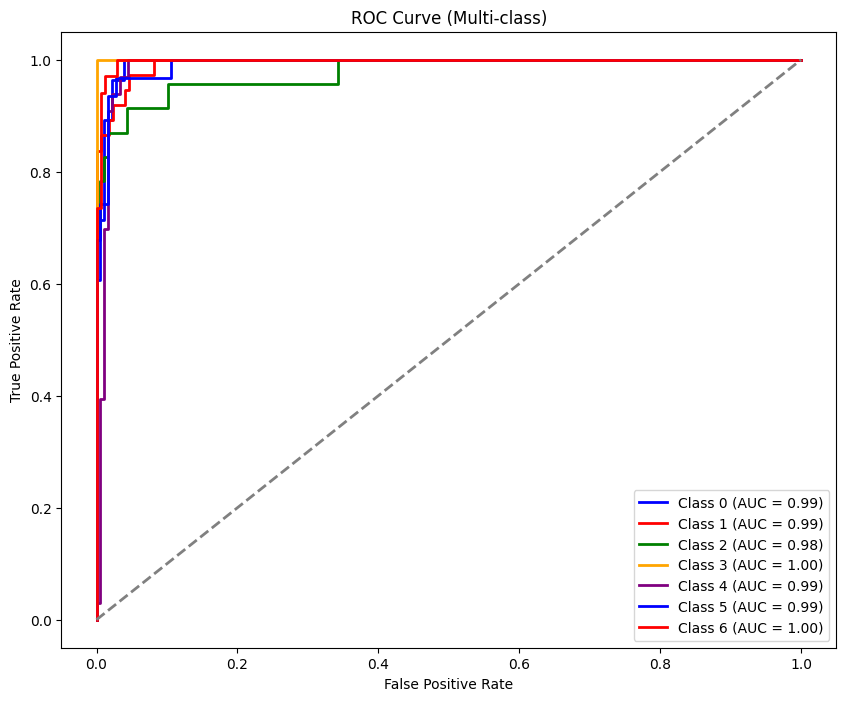

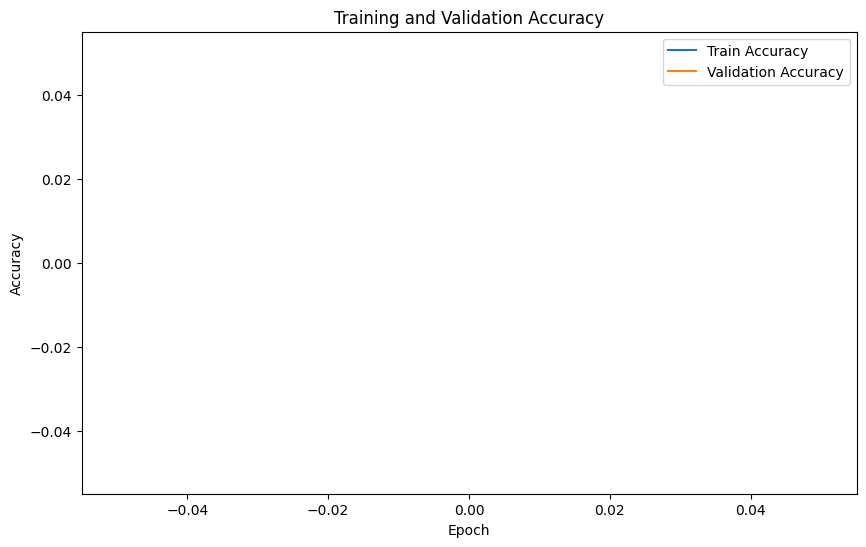

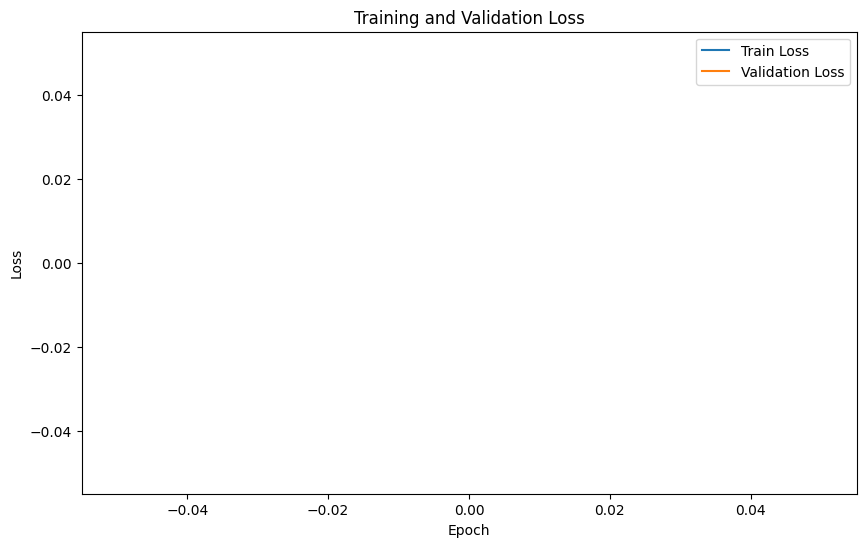

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

#  Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, digits=4))

#  Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=list(range(len(conf_matrix))), yticklabels=list(range(len(conf_matrix))))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#  ROC Curve (for multi-class, using One-vs-Rest)
n_classes = len(np.unique(all_labels))
if n_classes == 2:
    # Binary classification
    roc_auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
    fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs)[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

else:
    # Multi-class classification
    from sklearn.preprocessing import label_binarize
    from itertools import cycle

    y_bin = label_binarize(all_labels, classes=np.arange(n_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = roc_auc_score(y_bin[:, i], np.array(all_probs)[:, i])

    plt.figure(figsize=(10, 8))
    colors = cycle(["blue", "red", "green", "orange", "purple"])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multi-class)")
    plt.legend(loc="lower right")
    plt.show()

#  Accuracy/Loss Plot
train_acc_history = []  # Add train_acc to this after each epoch in the loop
val_acc_history = []    # Add val_acc to this after each epoch in the loop
train_loss_history = [] # Add running_loss/len(train_loader) to this after each epoch in the loop
val_loss_history = []   # Add val_loss to this after each epoch in the loop

plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


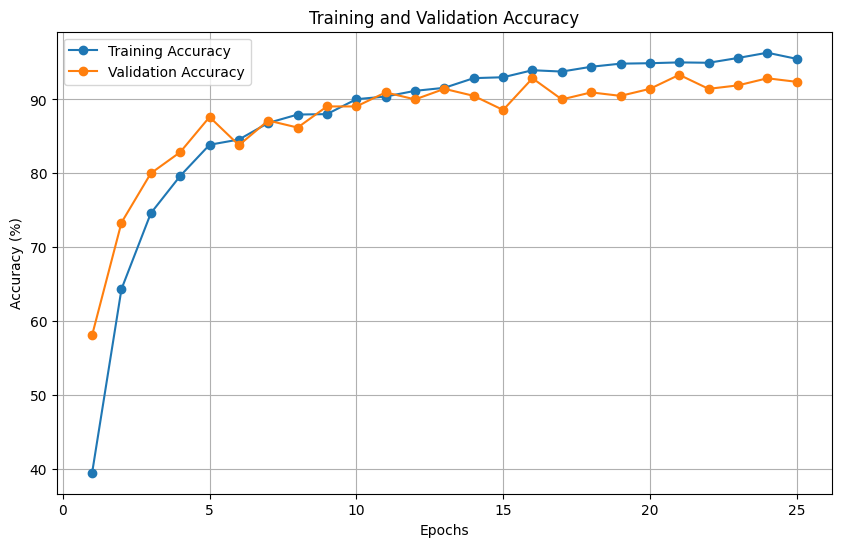

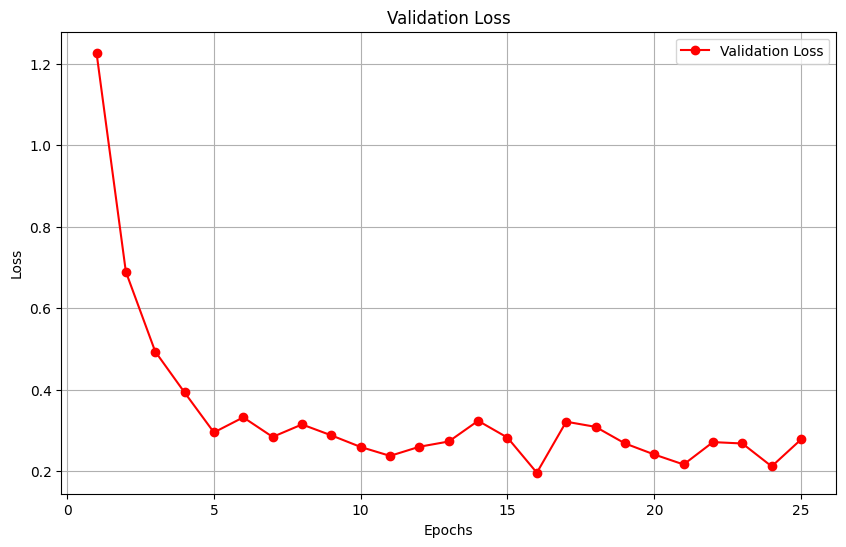

In [11]:
import matplotlib.pyplot as plt

# Data from training log
epochs = list(range(1, 26))
train_acc = [39.47, 64.33, 74.60, 79.64, 83.86, 84.57, 86.82, 87.95, 88.01, 90.03,
             90.39, 91.16, 91.57, 92.88, 93.00, 93.95, 93.77, 94.42, 94.84, 94.90,
             95.01, 94.96, 95.61, 96.32, 95.49]
val_acc = [58.10, 73.33, 80.00, 82.86, 87.62, 83.81, 87.14, 86.19, 89.05, 89.05,
           90.95, 90.00, 91.43, 90.48, 88.57, 92.86, 90.00, 90.95, 90.48, 91.43,
           93.33, 91.43, 91.90, 92.86, 92.38]
val_loss = [1.2266, 0.6894, 0.4938, 0.3934, 0.2954, 0.3324, 0.2844, 0.3150, 0.2882, 0.2597,
            0.2379, 0.2603, 0.2732, 0.3239, 0.2827, 0.1966, 0.3217, 0.3091, 0.2685, 0.2413,
            0.2168, 0.2717, 0.2683, 0.2121, 0.2782]

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='red')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
